# Recommendations Systems Project

## Data Loading and Exploration

### Loading the dataset

In [1]:
# Import all necessary libraries for project
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Recommendation System
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors  # For implementing collaborative filtering

# Setting styles and configurations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import train_test_split

from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np


#full_palette = sns.color_palette("", 10)
#subset_palette = full_palette[1:]
#sns.set_palette(full_palette)

# Load the datasets
#ratings_path = "data/raw/ratings.csv"
#movies_path = "data/raw/movies.csv"
#links_path = "data/raw/links.csv"
#tags_path = "data/raw/tags.csv"

#ratings_df = pd.read_csv(ratings_path)
#movies_df = pd.read_csv(movies_path)
#links_df = pd.read_csv(links_path)  # Optional for now
#tags_df = pd.read_csv(tags_path)    # Optional for now


In [2]:
ratings_path = "data/raw/ratings.csv"
ratings_df = pd.read_csv(ratings_path)

# Display the first few rows of the dataframe
print(ratings_df.head())


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


### Statistics 

In [3]:
# Number of unique users
num_users = ratings_df['userId'].nunique()
print(f"Number of unique users: {num_users}")

# Number of unique movies
num_movies = ratings_df['movieId'].nunique()
print(f"Number of unique movies: {num_movies}")

# Distribution of ratings
rating_counts = ratings_df['rating'].value_counts().sort_index()
print("\nDistribution of ratings:")
print(rating_counts)


Number of unique users: 610
Number of unique movies: 9724

Distribution of ratings:
rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


In [4]:
(ratings_df.shape)

(100836, 4)

In [5]:
(ratings_df.size)

403344

Check missing values

In [6]:
# Checking for missing values 
missing_values = ratings_df.isnull().sum()
print("Missing values per column:")
print(missing_values)


Missing values per column:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Check for outliers 

In [7]:
# Check for ratings outside the expected range
outliers = ratings_df[(ratings_df['rating'] < 0.5) | (ratings_df['rating'] > 5.0)]
print(outliers)


Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


Data types 


In [8]:
# Check data types of each column
print(ratings_df.dtypes)


userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


Duplicates 

In [9]:
# Check for duplicate rows
duplicates = ratings_df[ratings_df.duplicated()]
print(duplicates)


Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


### Visualisations

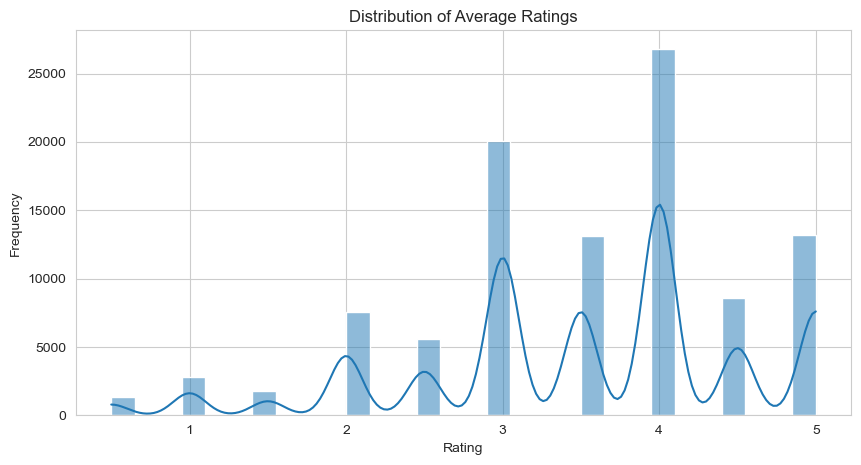

In [10]:
# Curious to see the rating distribution across all movies 
# Average rating distribution
plt.figure(figsize=(10, 5))
sns.histplot(ratings_df['rating'], bins=30, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


Most movies have average to slightly above-average ratings.
Very few movies have extremely high or low ratings. This could mean that most movies are of average quality, or users tend to rate movies they watch more favorably.
Implication: The recommendation system should be able to handle a majority of average-rated movies while also identifying the outliers (very high or very low-rated movies).

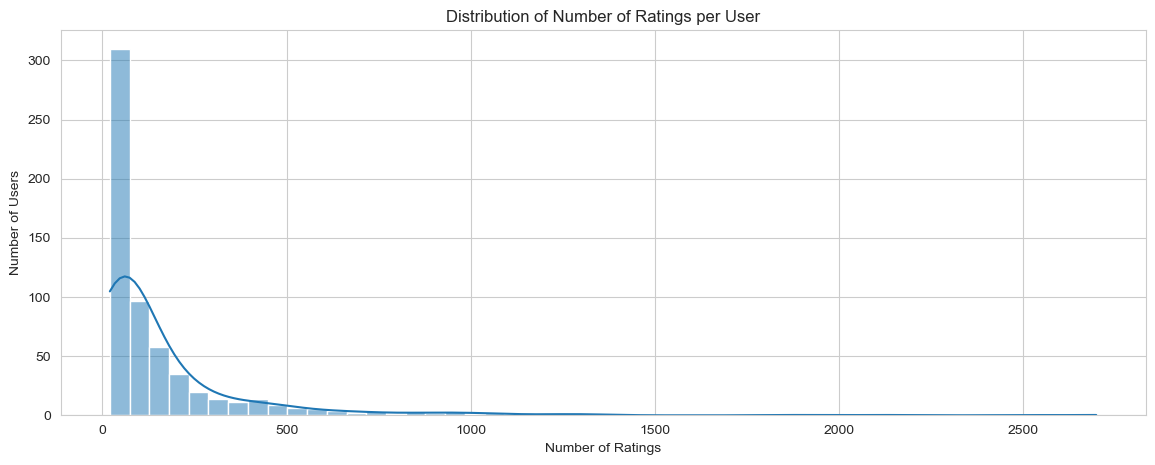

In [11]:
# Distribution of the number of ratings per user
user_ratings_count = ratings_df.groupby('userId').size()
plt.figure(figsize=(14, 5))
sns.histplot(user_ratings_count, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


Most users have rated only a few movies. This could present a cold start problem for new users or users with very few ratings.
Implication: We might need to consider hybrid recommendation methods that can handle users with few or no ratings.

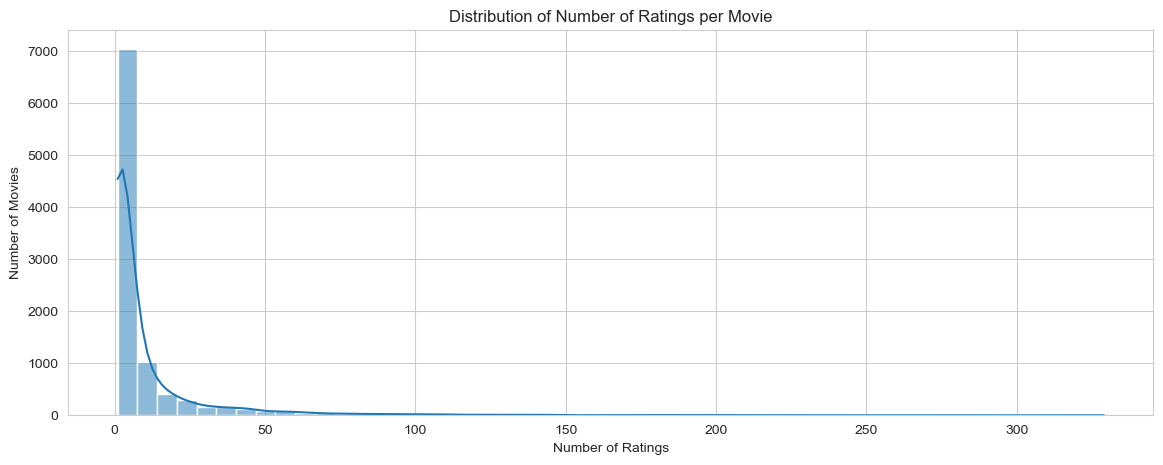

In [12]:
# Distribution of the number of ratings per movie
movie_ratings_count = ratings_df.groupby('movieId').size()
plt.figure(figsize=(14, 5))
sns.histplot(movie_ratings_count, bins=50, kde=True)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

Most movies have few ratings, which could mean they are either new, less popular, or not easily accessible.
Implication: The recommendation system should be robust enough to handle movies with few ratings.

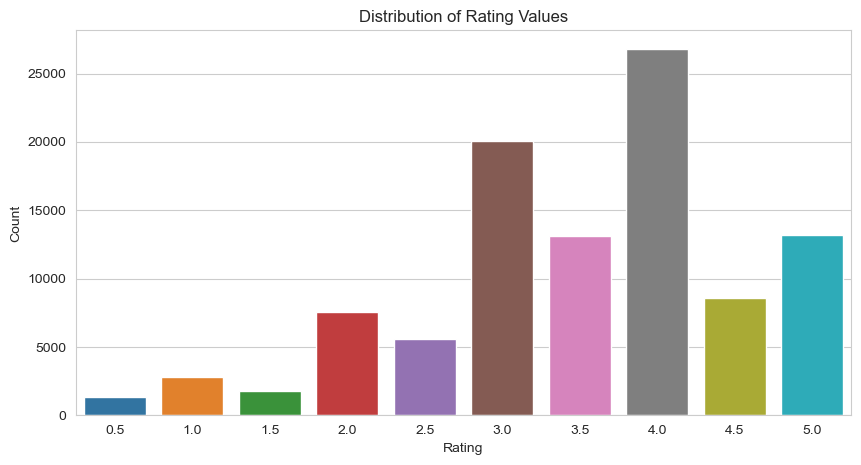

In [13]:
# Distribution of ratings values
plt.figure(figsize=(10, 5))
sns.countplot(data=ratings_df, x='rating')
plt.title('Distribution of Rating Values')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Most ratings are around the 4.0 mark, indicating a possible bias in user ratings or that users tend to watch movies they believe they'll like.
Implication: The recommendation system should be aware of this bias when making predictions.

The graph is a bell curve shape, indicating a normal distribution.
The peak of the curve is around 3.5, suggesting that the majority of users have an average rating of 3.5.


### Time stamp analysis 

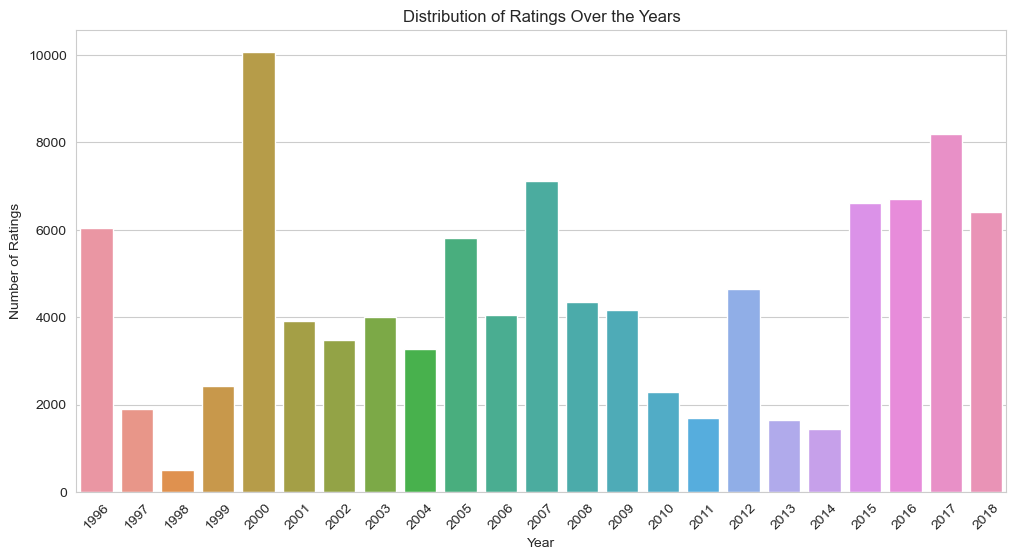

In [14]:
# Convert timestamp to datetime
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Extract year for further analysis
ratings_df['year'] = ratings_df['datetime'].dt.year

# Distribution of ratings over the years
plt.figure(figsize=(12, 6))
sns.countplot(data=ratings_df, x='year')
plt.title('Distribution of Ratings Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()



There's a decrease in the number of ratings over the years. This could be due to various reasons, such as increased competition in movie platforms, changes in user behavior, or the dataset not capturing all recent ratings.
Implication: The recommendation system might need to give more weight to recent ratings or consider temporal dynamics.

#### Some feature engineering 

In [15]:
# Average rating per user
user_avg_rating = ratings_df.groupby('userId')['rating'].mean()


# Average rating per movie
movie_avg_rating = ratings_df.groupby('movieId')['rating'].mean()


# Number of ratings per user
user_rating_count = ratings_df.groupby('userId').size()


# Number of ratings per movie
movie_rating_count = ratings_df.groupby('movieId').size()


### Collaborative Filter Modelling

Train-Test Split 

In [16]:
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)


Singular Value Decomposition (SVD)

In [17]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Define a reader and the rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data
data = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

# Use SVD algorithm
algo = SVD()

# Cross validate on the data
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8813  0.8740  0.8766  0.8832  0.8791  0.8788  0.0033  
MAE (testset)     0.6741  0.6760  0.6792  0.6798  0.6751  0.6768  0.0023  
Fit time          2.01    1.96    1.97    1.93    2.22    2.02    0.10    
Test time         0.26    0.27    0.46    0.30    0.27    0.31    0.07    


{'test_rmse': array([0.88126668, 0.87400087, 0.87662543, 0.88315285, 0.87909805]),
 'test_mae': array([0.67406343, 0.67601459, 0.67923444, 0.67979513, 0.67513073]),
 'fit_time': (2.007244825363159,
  1.9600050449371338,
  1.9668331146240234,
  1.9329781532287598,
  2.2174737453460693),
 'test_time': (0.2595536708831787,
  0.2704474925994873,
  0.45692873001098633,
  0.29810643196105957,
  0.26770448684692383)}

GridSearch

In [18]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

# Define a parameter grid to search
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [5,10],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Use GridSearchCV with the SVD algorithm and the defined parameter grid
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

# Use the same dataset as before
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))

# Fit the grid search
gs.fit(data)

# Get the best parameters and the corresponding RMSE and MAE scores
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])
print(gs.best_params['mae'])
print(gs.best_score['mae'])


{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
0.8908589404630908
{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
0.6895773058498073


Tuning hyperparameters 

In [24]:
from surprise.model_selection import train_test_split

# Load your dataset
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the dataset into train and test
trainset, testset = train_test_split(data, test_size=0.25)

# Define the algorithm with optimal hyperparameters
algo = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset
algo.fit(trainset)



Prediction

In [25]:
# Predict ratings for the testset
predictions = algo.test(testset)

# Example: Predict a rating for a specific user and item
user_id = 1
item_id = 302
actual_rating = 3.5
print(algo.predict(user_id, item_id, actual_rating))


user: 1          item: 302        r_ui = 3.50   est = 4.05   {'was_impossible': False}


### Evaluating using a subset of the data

In [26]:
predictions = algo.test(testset)

from surprise import accuracy

rmse = accuracy.rmse(predictions)
print(f"Root Mean Squared Error: {rmse:.4f}")

mae = accuracy.mae(predictions)
print(f"Mean Absolute Error: {mae:.4f}")



RMSE: 0.8953
Root Mean Squared Error: 0.8953
MAE:  0.6910
Mean Absolute Error: 0.6910


Cross-validation with KNNBasic

In [27]:
from surprise import KNNBasic
from surprise.model_selection import cross_validate

# Initialize KNNBasic model
knn_basic = KNNBasic()

# Cross validate with the data
cv_knn_basic = cross_validate(knn_basic, data, measures=['RMSE'], cv=5, verbose=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9562  0.9534  0.9535  0.9446  0.9370  0.9490  0.0071  
Fit time          0.77    0.73    0.76    0.73    0.79    0.76    0.02    
Test time         5.03    3.68    4.43    4.33    5.44    4.58    0.61    


Cross-validation wih KNNBaseline 

In [28]:
from surprise import KNNBaseline

# Initialize KNNBaseline model
knn_baseline = KNNBaseline()

# Cross validate with the data
cv_knn_baseline = cross_validate(knn_baseline, data, measures=['RMSE'], cv=5, verbose=True)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8770  0.8821  0.8755  0.8675  0.8737  0.8751  0.0048  
Fit time          2.59    1.38    1.53    1.76    1.66    1.78    0.42    
Test time         5.22    5.09    8.89    6.28    6.33    6.36    1.37    


### (Optional) Implement item-based collaborative filtering 

## Addressing the Cold Start Problem 

### Implement a basic content-based filtering mechanism

## Evaluation

### Split the data

### Train the model

### Predict and evaluate using RMSE and MAE

## User Interaction

### Design simple mechanism for users to input their ratings

## Recommendation

### Based on user input, recommend the top 5 movies